In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation
%matplotlib ipympl
plt.rcParams['figure.figsize'] = [10, 4]
writervideo = matplotlib.animation.FFMpegWriter(fps=30)

import numpy as np
import pandas as pd

from numba import njit
import timeit
import random
from scipy.spatial import KDTree, cKDTree
from scipy.stats import linregress
from scipy import spatial

from scipy.ndimage import uniform_filter1d
from scipy.signal import savgol_filter
import joblib
from tqdm import tqdm
import pims

import trackpy as tp
tp.quiet()

from yupi import Trajectory
import yupi.graphics as yg
import yupi.stats as ys

# Import data

In [2]:
data = pims.open('/Volumes/ExtremeSSD/UNI/thesis/ThesisData/data_video/movie.mp4')

17:37:25 [WARNING] deprecated pixel format used, make sure you did set range correctly


In [3]:
rawTrajs = pd.read_csv("/Volumes/ExtremeSSD/UNI/thesis/ThesisData/data/Processed_data2.csv")
rawTrajs.loc[rawTrajs.particle!=17, ["color"]] = "#00007F"
rawTrajs.loc[rawTrajs.particle==17, ["color"]] = "#FF0000"

nDrops = len(rawTrajs.loc[rawTrajs.frame==0])
nFrames = max(rawTrajs.frame)
print(f"nDrops:{nDrops}")
print(f"nFrames:{nFrames} --> {nFrames/10:.2f} s")

red_particle_idx = 17
colors = []
for i in range(red_particle_idx):
    colors.append("#000000")
colors.append("#FF5733")
for i in range(red_particle_idx+1, nDrops):
    colors.append("#000000")

nDrops:50
nFrames:31999 --> 3199.90 s


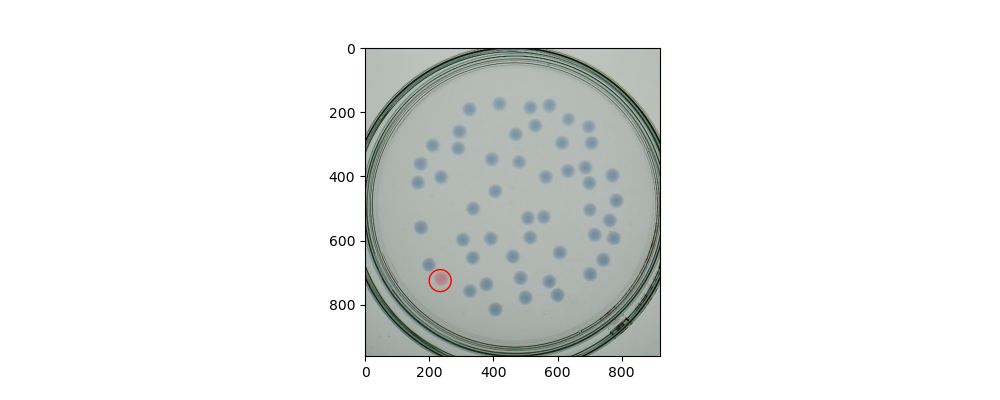

In [4]:
df = rawTrajs.loc[(rawTrajs.frame == 0) & (rawTrajs.particle == red_particle_idx), ["x","y","color"]]
fig, ax = plt.subplots(1,1)
ax.scatter(df.x, df.y, facecolors = 'none', edgecolors = df.color, s = 250)
ax.imshow(data[0])
plt.show()

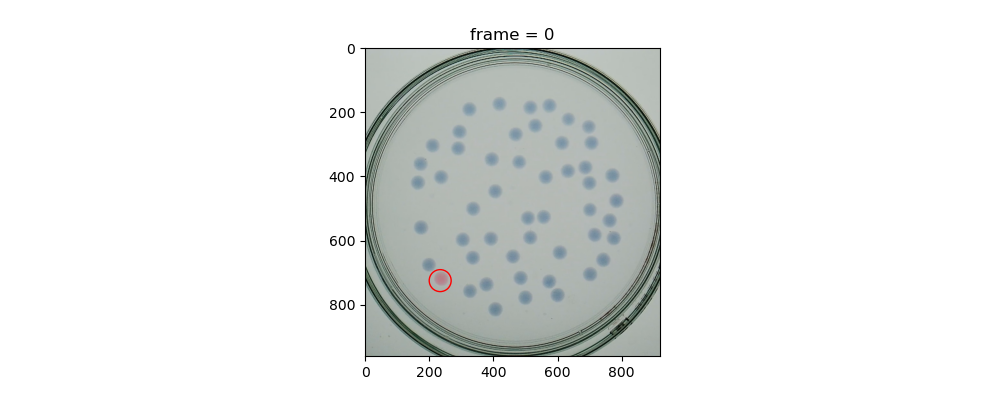

In [8]:
if 0:
    fig = plt.figure()
    anim_running = True

    def onClick(event):
        global anim_running
        if anim_running:
            ani.event_source.stop()
            anim_running = False
        else:
            ani.event_source.start()
            anim_running = True

    def update_graph(frame):
        df = rawTrajs.loc[(rawTrajs.frame == frame) & (rawTrajs.particle == red_particle_idx) , ["x","y","color"]]
        graph.set_offsets(df)
        graph.set_edgecolor(df.color)
        graph2.set_data(data[frame])
        title.set_text('frame = {}'.format(frame))
        return graph

    ax = fig.add_subplot(111)
    title = ax.set_title('frame = 0')
    df = rawTrajs.loc[(rawTrajs.frame == 0) & (rawTrajs.particle == red_particle_idx), ["x","y","color"]]

    graph = ax.scatter(df.x, df.y, facecolors = 'none', edgecolors = df.color, s = 250)

    graph2 = ax.imshow(data[0])

    fig.canvas.mpl_connect('button_press_event', onClick)
    ani = matplotlib.animation.FuncAnimation(fig, update_graph, nFrames, interval = 5, blit=False)
    #ani.save(f'/Users/matteoscandola/thesisData/videos/full_video/try.mp4', writer=writervideo)
    plt.show()

# Trajectory Smoothing

Smoothing of the trajectory using a Savgol Filter in order to drop the noise due to the tracking procedure

In [6]:
smoothTrajs = rawTrajs.copy()

# Parameters of the Savgol Filter to smooth the trajectories
windLen = 30
orderofPoly = 2
for i in range(nDrops):
    smoothTrajs.loc[smoothTrajs.particle == i, "x"] = savgol_filter(rawTrajs.loc[rawTrajs.particle == i].x.values, windLen, orderofPoly)
    smoothTrajs.loc[smoothTrajs.particle == i, "y"] = savgol_filter(rawTrajs.loc[rawTrajs.particle == i].y.values,  windLen, orderofPoly)

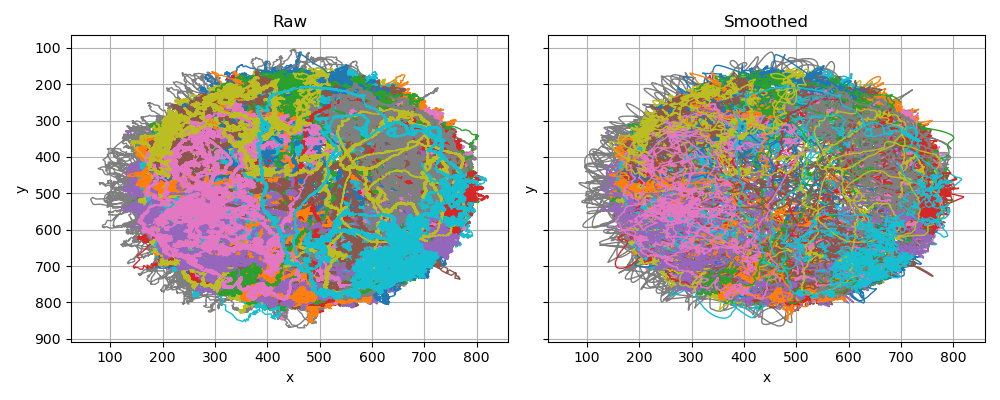

In [7]:
fig, (ax, ax1) = plt.subplots(1, 2, sharex=True, sharey=True)
tp.plot_traj(rawTrajs, ax = ax)
tp.plot_traj(smoothTrajs, ax = ax1)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax.set_title("Raw")
ax1.set_title("Smoothed")
ax.grid()
ax1.grid()
plt.tight_layout()
plt.show()

# Trajectory Analysis

## Mean Squared Displacement

In [18]:
# Power Law fit
def powerLawFit(funct, fit, powerlawExponents):
    for i in range(nDrops):
        powerlawFit = tp.utils.fit_powerlaw(funct[i], plot = False)  #[10:]
        powerlawExponents[i] = powerlawFit.n.values 
        fit[i] = powerlawFit.A.values * np.array(funct.index)**powerlawExponents[i] #[10:]
    return fit, powerlawExponents

In [22]:

# Mean Squared Displacement per Particle
pxDimension = 1 # has to be fixed 
fps = 10 # fps of the video
maxLagtime = 1000 # maximum lagtime to be considered
im = tp.imsd(rawTrajs, mpp = pxDimension, fps = fps, max_lagtime = maxLagtime)

# Power Law fit
fit, powerlawExponents = powerLawFit(im, np.zeros((nDrops, maxLagtime)), np.zeros(nDrops))

# Mean Squared Displacement per Particle
pxDimension = 1 # has to be fixed 
fps = 10 # fps of the video
maxLagtime = 1000 # maximum lagtime to be considered
im2 = tp.imsd(smoothTrajs, mpp = pxDimension, fps = fps, max_lagtime = maxLagtime)

# Power Law fit
fit2, powerlawExponents2 = powerLawFit(im, np.zeros((nDrops, maxLagtime)), np.zeros(nDrops))

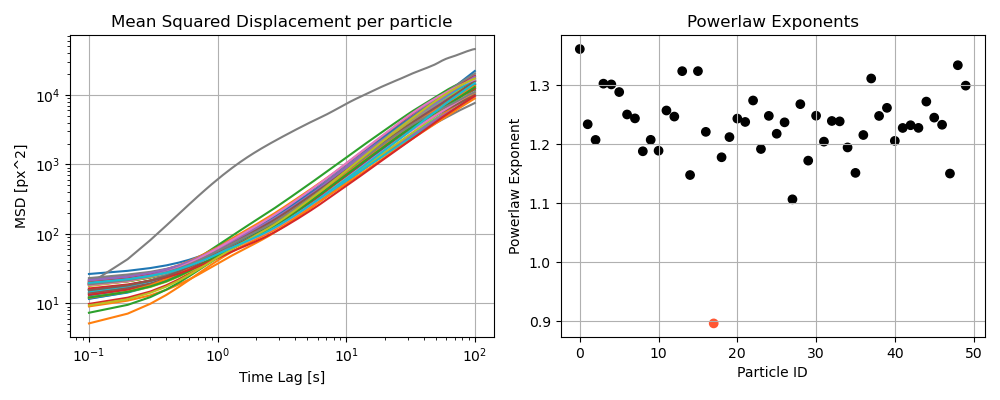

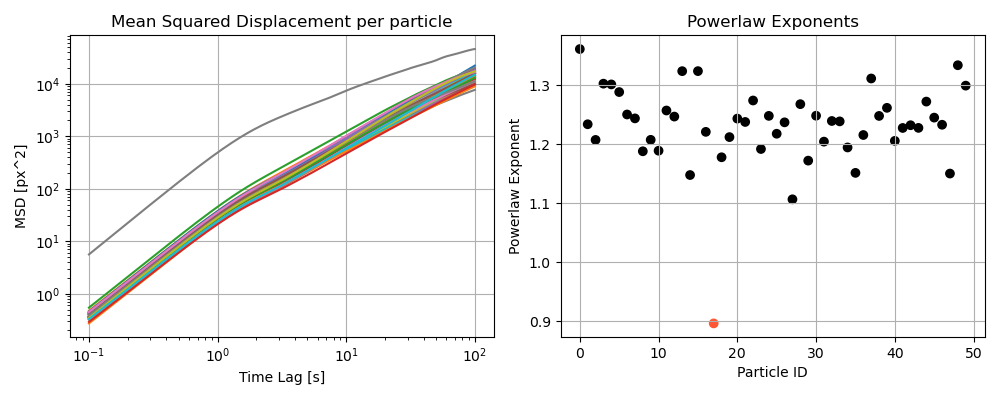

In [23]:
fig, (ax, ax1) = plt.subplots(1, 2)
ax.plot(im.index, im)#, alpha=0.5)  
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title("Mean Squared Displacement per particle")
ax.set_xlabel("Time Lag [s]")
ax.set_ylabel("MSD [px^2]")
ax.grid()
ax1.scatter(np.arange(nDrops), powerlawExponents, c = colors)
ax1.set_title("Powerlaw Exponents")
ax1.set_xlabel("Particle ID")
ax1.set_ylabel("Powerlaw Exponent")
ax1.grid()
plt.tight_layout()
plt.show()
       
fig, (ax, ax1) = plt.subplots(1, 2)
ax.plot(im.index, im2)#, alpha=0.5)  
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title("Mean Squared Displacement per particle")
ax.set_xlabel("Time Lag [s]")
ax.set_ylabel("MSD [px^2]")
ax.grid()
ax1.scatter(np.arange(nDrops), powerlawExponents2, c = colors)
ax1.set_title("Powerlaw Exponents")
ax1.set_xlabel("Particle ID")
ax1.set_ylabel("Powerlaw Exponent")
ax1.grid()
plt.tight_layout()
plt.show()

In [ ]:

# Check if this is the red particle --> Confirmed
print(f"The particle with the highest MSD is the particle number: {idx} and its the red particle!")
frame = 1000
fig, (ax,ax1) = plt.subplots(1, 2, figsize = (10, 6), sharex=True, sharey=True)
ax.imshow(data[frame])
ax.scatter(rawTrajs.loc[rawTrajs.frame == frame].x, rawTrajs.loc[rawTrajs.frame == frame].y, facecolors = 'none', edgecolors = rawTrajs.loc[rawTrajs.frame == frame].color, s = 350)
ax.set_title("raw")
ax.set_xlabel("X [px]")
ax.set_ylabel("Y [px]")
ax1.imshow(data[frame])
ax1.scatter(smoothTrajs.loc[smoothTrajs.frame == frame].x, smoothTrajs.loc[smoothTrajs.frame == frame].y, facecolors = 'none', edgecolors = smoothTrajs.loc[smoothTrajs.frame == frame].color, s = 350)
ax1.set_xlabel("X [px]")
ax1.set_ylabel("Y [px]")
ax1.set_title("smoothed")
plt.tight_layout()
plt.suptitle("Identification of the particle with the highest MSD")
plt.show()

In [31]:
em = tp.emsd(rawTrajs.loc[rawTrajs.particle != red_particle_idx], mpp = pxDimension, fps = fps, max_lagtime = maxLagtime)
powerlawFit = tp.utils.fit_powerlaw(em[10:], plot = False)  
fit = powerlawFit.A.values * np.array(em.index[10:])**powerlawFit.n.values 

em_red = tp.emsd(rawTrajs.loc[rawTrajs.particle == red_particle_idx], mpp = pxDimension, fps = fps, max_lagtime = maxLagtime)
powerlawFit_red = tp.utils.fit_powerlaw(em_red[10:], plot = False)  
fit_red = powerlawFit_red.A.values * np.array(em_red.index[10:])**powerlawFit_red.n.values 

print(f"Power Law exponent for blue particles: {powerlawFit.n.values[0]}")
print(f"Power Law exponent for red particle: {powerlawFit_red.n.values[0]}")

Power Law exponent for blue particles: 1.250378806019201
Power Law exponent for red particle: 0.7802348034801061


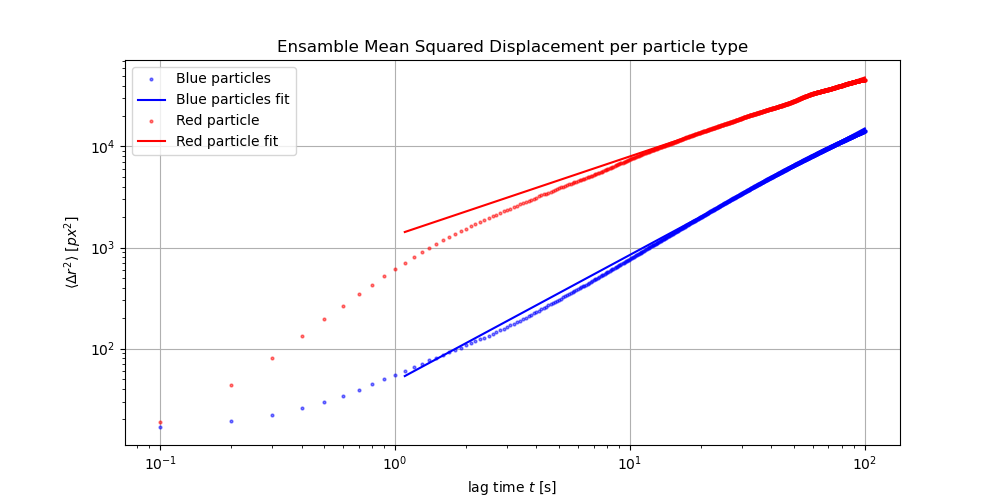

In [32]:
if 1:
    fig, ax = plt.subplots(figsize = (10, 5))
    ax.plot(em.index, em, 'bo', markersize=2, alpha=0.5, label = "Blue particles")
    ax.plot(em.index[10:], fit, 'b-', label='Blue particles fit')

    ax.plot(em_red.index, em_red, 'ro', markersize=2, alpha=0.5, label = "Red particle")
    ax.plot(em_red.index[10:], fit_red, 'r-', label='Red particle fit')

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set(ylabel = r'$\langle \Delta r^2 \rangle$ [$px^2$]', xlabel = 'lag time $t$ [s]')
    plt.grid()
    plt.title("Ensamble Mean Squared Displacement per particle type")
    plt.legend()
    plt.show()

In [27]:
MSD_mean = np.array(im)
print(MSD_mean.shape)
MSD_blue = MSD_mean[:, [x for x in range(nDrops) if x != red_particle_idx]].mean(axis = 1)
MSD_blue_std = MSD_mean[:,[x for x in range(nDrops) if x != red_particle_idx]].std(axis = 1)
MSD_red = MSD_mean[:, red_particle_idx]

(1000, 50)


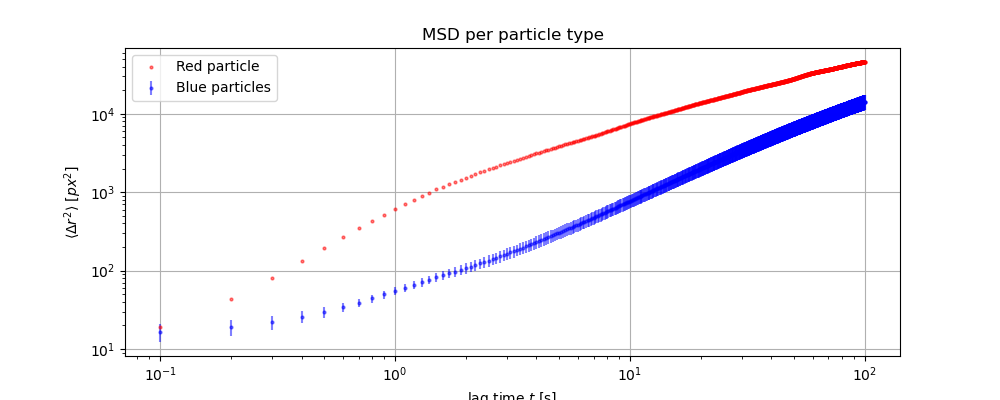

In [36]:
fig, ax = plt.subplots(1,1)
ax.errorbar(im.index, MSD_blue, yerr = MSD_blue_std, fmt = 'bo', markersize=2, alpha=0.5, label = "Blue particles")
ax.plot(im.index, MSD_red, 'ro', markersize=2, alpha=0.5, label = "Red particle")
ax.set(ylabel = r'$\langle \Delta r^2 \rangle$ [$px^2$]', xlabel = 'lag time $t$ [s]', title = "MSD per particle type")
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
plt.grid()
plt.show()

## Windowed Mean Squared Displacement

In [3]:
# Power Law fit
def powerLawFit(funct, fit, powerlawExponents):
    for i in range(nDrops):
        powerlawFit = tp.utils.fit_powerlaw(funct[i], plot = False)  #[10:]
        powerlawExponents[i] = powerlawFit.n.values 
        fit[i] = powerlawFit.A.values * np.array(funct.index)**powerlawExponents[i] #[10:]
    return fit, powerlawExponents

In [4]:
# run with a 200 s window
totTime = nFrames/10
print("total time:", totTime, "seconds")
timeWindow = 320 # seconds 
nWindows = int(totTime/timeWindow) + 1
print(nWindows, "windows")
pxDimension = 1 # has to be fixed 
fps = 10 # fps of the video
maxLagtime = 1000 # maximum lagtime to be considered --> 100s

total time: 3199.9 seconds
10 windows


In [5]:
MSD_windowed = []
fit_windowed = np.zeros((nWindows, nDrops, maxLagtime))#maxLagtime-10
powerlawExponents_windowed = np.zeros((nWindows, nDrops))

for k in tqdm(range(nWindows)):
    trajs = rawTrajs[k*nDrops*timeWindow*fps : (k+1)*nDrops*timeWindow*fps]
    MSD_windowed.append(tp.imsd(trajs, mpp = pxDimension, fps = fps, max_lagtime = maxLagtime))
    
    fit_windowed[k], powerlawExponents_windowed[k] = powerLawFit(MSD_windowed[k], np.zeros((nDrops, maxLagtime)), np.zeros(nDrops))

100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


In [6]:
if 0: 
    fig, axs = plt.subplots(2, nWindows, figsize = (50, 6))
    for k in range(nWindows):
        axs[0, k].plot(MSD_windowed[k].index, MSD_windowed[k])
        axs[0, k].set_xscale('log')
        axs[0, k].set_yscale('log')
        axs[0, k].set_title(f"{k*timeWindow}-{(k+1)*timeWindow} seconds")
        axs[1, k].scatter(np.arange(nDrops), powerlawExponents_windowed[k], c = colors)
    plt.tight_layout()
    plt.savefig("/Volumes/ExtremeSSD/UNI/thesis/Results/msd_time_windowed/msd2.png", dpi = 300)
    plt.close()

In [8]:
MSD_windowed_mean = np.array(MSD_windowed)
MSD_windowed_blue = MSD_windowed_mean[:, :, [x for x in range(nDrops) if x != red_particle_idx]].mean(axis = 2)
MSD_windowed_blue_std = MSD_windowed_mean[:, :, [x for x in range(nDrops) if x != red_particle_idx]].std(axis = 2)
MSD_windowed_red = MSD_windowed_mean[:, :, red_particle_idx]

In [9]:
MSD_windowed_blue.shape
MSD_windowed_blue_std.shape

(10, 1000)

In [10]:
df_blue = []
df_red = []
for k in range(nWindows):
    df_blue.append(pd.DataFrame(data = MSD_windowed_blue[k], index = MSD_windowed[0].index, columns = ['window']))
    df_red.append(pd.DataFrame(data = MSD_windowed_red[k], index = MSD_windowed[0].index, columns = ['window']))


In [43]:
fit_mean = np.zeros((nWindows, 2, maxLagtime-10))
powerlawExponents_mean = np.zeros((nWindows, 2))
powerlawExponents_std = np.zeros((nWindows, 2))

for k in range(nWindows):
    powerlawFit = tp.utils.fit_powerlaw(df_blue[k].iloc[10:], plot = False)  
    #print(powerlawFit)
    powerlawExponents_mean[k, 0] = powerlawFit.n.values 
    powerlawExponents_std[k, 0] = powerlawFit.stderr.values 
    fit_mean[k, 0, :] = powerlawFit.A.values * np.arange(1.1, 100.1, 0.1)**powerlawExponents_mean[k, 0]

    powerlawFit = tp.utils.fit_powerlaw(df_red[k].iloc[10:], plot = False)  
    powerlawExponents_mean[k, 1] = powerlawFit.n.values 
    powerlawExponents_std[k, 1] = powerlawFit.stderr.values 
    fit_mean[k, 1, :] = powerlawFit.A.values * np.arange(1.1, 100.1, 0.1)**powerlawExponents_mean[k, 1]
    

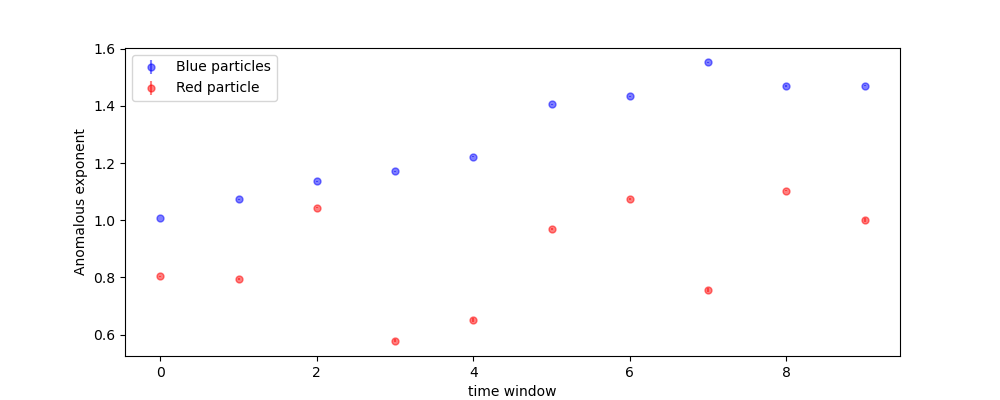

In [44]:
fig, ax = plt.subplots(1,1)
ax.errorbar(np.arange(0, nWindows, 1), powerlawExponents_mean[:, 0], yerr = powerlawExponents_std[:, 0], fmt = 'bo', markersize=5, alpha=0.5, label = "Blue particles")
ax.errorbar(np.arange(0, nWindows, 1), powerlawExponents_mean[:, 1], yerr = powerlawExponents_std[:, 1], fmt = 'ro', markersize=5, alpha=0.5, label = "Red particle")
ax.legend()
ax.set_xlabel("time window")
ax.set_ylabel("Anomalous exponent")
plt.show()

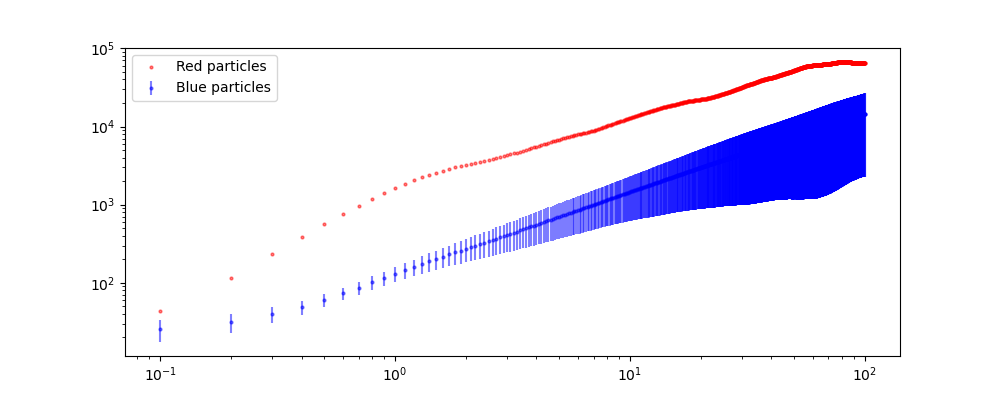

In [41]:
k = 0
fig, ax = plt.subplots(1, 1)
ax.errorbar(df_blue[k].index, df_blue[k].window, yerr = MSD_windowed_blue_std[k], fmt = 'bo', markersize=2, alpha=0.5, label = "Blue particles")
ax.plot(df_red[k].index, df_red[k].window, 'ro', markersize=2, alpha=0.5, label = "Red particles")
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
plt.show()

In [57]:
if 1: 
    fig, axs = plt.subplots(1, nWindows, figsize = (50, 3))
    for k in range(nWindows):
        axs[k].errorbar(df_blue[k].index, MSD_windowed_blue[k], yerr = MSD_windowed_blue_std[k], fmt = 'bo', markersize=2, alpha=0.5, label = "Blue particles") #.plot(df_blue[k].index, df_blue[k], 'bo', markersize=2, alpha=1, label = "Blue particles") 
        axs[k].plot(df_blue[k].index[10:], fit_mean[k, 0], 'b-', alpha=0.5, label = '')
        axs[k].plot(df_red[k].index, df_red[k], 'ro', markersize=2, alpha=0.5, label = "Blue particles") 
        axs[k].plot(df_red[k].index[10:], fit_mean[k, 1], 'r-', alpha=0.5, label = 'red particles fit')

        axs[k].set_xscale('log')
        axs[k].set_yscale('log')
        axs[k].set_title(f"{k*timeWindow}-{(k+1)*timeWindow} seconds")
        axs[k].legend()
        
        
    plt.tight_layout()
    plt.savefig("/Volumes/ExtremeSSD/UNI/thesis/Results/msd_time_windowed/msd_mean2.png", dpi = 300)
    plt.close()

## Other metrics

In [58]:
blueTrajs = []
redTraj = []
for i in range(0, nDrops):
    if i != red_particle_idx:
        p1 = rawTrajs.loc[np.where(rawTrajs.particle==i)[0], ["x","y"]]
        blueTrajs.append(Trajectory(p1.x, p1.y, dt = 1/10, traj_id=i))
    if i == red_particle_idx:
        p1 = rawTrajs.loc[np.where(rawTrajs.particle==i)[0], ["x","y"]]
        redTraj.append(Trajectory(p1.x, p1.y, dt = 1/10, traj_id=i))



blueTrajs_smooth = []
redTraj_smooth = []
for i in range(0, nDrops):
    if i != red_particle_idx:
        p1 = smoothTrajs.loc[np.where(smoothTrajs.particle==i)[0], ["x","y"]]
        blueTrajs_smooth.append(Trajectory(p1.x, p1.y, dt = 1/10, traj_id=i))
    if i == red_particle_idx:
        p1 = smoothTrajs.loc[np.where(smoothTrajs.particle==i)[0], ["x","y"]]
        redTraj_smooth.append(Trajectory(p1.x, p1.y, dt = 1/10, traj_id=i))

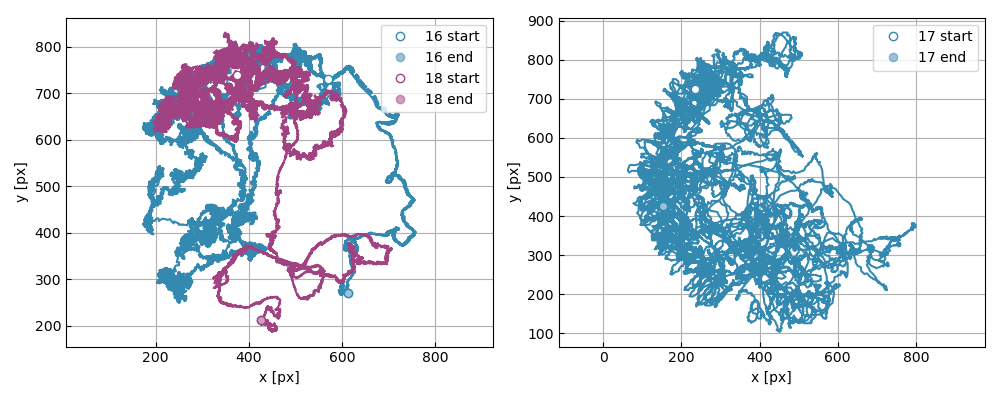

In [59]:
# Trajectories plot to check if trajectories ID are correct
fig = plt.figure(figsize=(10, 4))
plt.subplot(121)
yg.plot_2d(blueTrajs[16:18], legend=True, units="px", show=False)
plt.subplot(122)
yg.plot_2d(redTraj, legend=True, units="px", show=False)
plt.tight_layout()
plt.show()

### Speed Distribution

In [ ]:
v_blue = ys.speed_ensemble(blueTrajs, step=10)
v_red = ys.speed_ensemble(redTraj, step=10)

fig = plt.figure(figsize=(9, 4))
plt.subplot(121)
plt.title("Blue particles velocity distribution")
yg.plot_speed_hist(v_blue, bins=100, units="px/s", show=False)
plt.subplot(122)
plt.title("Red particle velocity distribution")
yg.plot_speed_hist(v_red, bins=100, units="px/s", show=False)
plt.tight_layout()
plt.show()


v_blue_smooth = ys.speed_ensemble(blueTrajs_smooth, step=10)
v_red_smooth = ys.speed_ensemble(redTraj_smooth, step=10)

fig = plt.figure(figsize=(9, 4))
plt.subplot(121)
plt.title("Blue particles velocity distribution")
yg.plot_speed_hist(v_blue_smooth, bins=100, units="px/s", show=False)
plt.subplot(122)
plt.title("Red particle velocity distribution")
yg.plot_speed_hist(v_red_smooth, bins=100, units="px/s", show=False)
plt.tight_layout()
plt.show()

### Speed Distribution Windowed

In [85]:
v_blue_windowed = []
v_red_windowed = []
for k in tqdm(range(nWindows)):
    trajs = rawTrajs[k*nDrops*timeWindow*fps : (k+1)*nDrops*timeWindow*fps]
    blueTrajs = []
    redTraj = []

    for i in range(0, nDrops):
        if i != red_particle_idx:
            p1 = trajs.loc[np.where(trajs.particle==i)[0] + k * 160000, ["x","y"]]
            blueTrajs.append(Trajectory(p1.x, p1.y, dt = 1/10, traj_id=i))
        if i == red_particle_idx:
            p1 = trajs.loc[np.where(trajs.particle==i)[0] + k * 160000, ["x","y"]]
            redTraj.append(Trajectory(p1.x, p1.y, dt = 1/10, traj_id=i))

    v_blue_windowed .append(ys.speed_ensemble(blueTrajs, step=10))
    v_red_windowed .append(ys.speed_ensemble(redTraj, step=10))

100%|██████████| 10/10 [00:03<00:00,  3.10it/s]


In [101]:
units="px/s"
default_kwargs = {"color": "#99d2ec", "ec": (0, 0, 0, 0.6), "density": True}
if 1: 
   fig, axs = plt.subplots(2, nWindows, figsize = (50, 3))
   for k in range(nWindows):
      axs[0, k].hist(v_blue_windowed[k], bins = 100, **default_kwargs)
      axs[0, k].set_title(f"Blue particles velocity pdf {k*timeWindow}-{(k+1)*timeWindow} s") 
      axs[0, k].set_xlim(0, 20)
      axs[0, k].set_ylim(0, 0.25)
      axs[0, k].set_xlabel(f"speed{units}")
      axs[0, k].set_ylabel("pdf")
      axs[0, k].grid()
      axs[1, k].hist(v_red_windowed[k], bins = 100, **default_kwargs)
      axs[1, k].set_title(f"Red particles velocity pdf {k*timeWindow}-{(k+1)*timeWindow} s") 
      axs[1, k].set_xlim(0, 70)
      axs[1, k].set_ylim(0, 0.2)
      axs[1, k].set_xlabel(f"speed{units}")
      axs[1, k].set_ylabel("pdf")
      axs[1, k].grid()
   plt.tight_layout()
   plt.savefig("/Volumes/ExtremeSSD/UNI/thesis/Results/msd_time_windowed/speed_ensamble.png", dpi = 300)
   plt.close()

### Turning Angles Distribution

In [ ]:
theta_blue = ys.turning_angles_ensemble(blueTrajs, centered= True)
theta_red = ys.turning_angles_ensemble(redTraj, centered= True)

default_kwargs = {"color": "#99d2ec", "ec": (0, 0, 0, 0.6), "density": True}
fig, (ax, ax1) = plt.subplots(1, 2, figsize=(10, 4))#, subplot_kw = dict(projection='polar'))
ax.hist(theta_blue, 100, **default_kwargs)
ax.set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],[r'-$\pi$', r'$-\frac{\pi}{2}$', '$0$', r'$\frac{\pi}{2}$', r'$\pi$'])
ax.set_title("Turning angles pdf for blue particles")

ax1.hist(theta_red, 100, **default_kwargs)
ax1.set_title("Turning angles pdf for red particle")
ax1.set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],[r'-$\pi$', r'$-\frac{\pi}{2}$', '$0$', r'$\frac{\pi}{2}$', r'$\pi$'])

plt.show()

In [ ]:
theta_blue_smooth = ys.turning_angles_ensemble(blueTrajs_smooth, centered = True)
theta_red_smooth = ys.turning_angles_ensemble(redTraj_smooth, centered = True)

fig, (ax, ax1) = plt.subplots(1, 2, figsize=(10, 4))
default_kwargs = {"color": "#99d2ec", "ec": (0, 0, 0, 0.6), "density": True}
ax.hist(theta_blue_smooth, 100, **default_kwargs)
ax.set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],[r'-$\pi$', r'$-\frac{\pi}{2}$', '$0$', r'$\frac{\pi}{2}$', r'$\pi$'])
ax.set_title("Turning angles pdf for blue particles")
ax1.hist(theta_red_smooth, 100, **default_kwargs)
ax1.set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],[r'-$\pi$', r'$-\frac{\pi}{2}$', '$0$', r'$\frac{\pi}{2}$', r'$\pi$'])
ax1.set_title("Turning angles pdf for red particle")
plt.show()

### Turning Angles Windowed

In [103]:
theta_blue_windowed = []
theta_red_windowed = []
for k in tqdm(range(nWindows)):
    trajs = rawTrajs[k*nDrops*timeWindow*fps : (k+1)*nDrops*timeWindow*fps]
    blueTrajs = []
    redTraj = []

    for i in range(0, nDrops):
        if i != red_particle_idx:
            p1 = trajs.loc[np.where(trajs.particle==i)[0] + k * 160000, ["x","y"]]
            blueTrajs.append(Trajectory(p1.x, p1.y, dt = 1/10, traj_id=i))
        if i == red_particle_idx:
            p1 = trajs.loc[np.where(trajs.particle==i)[0] + k * 160000, ["x","y"]]
            redTraj.append(Trajectory(p1.x, p1.y, dt = 1/10, traj_id=i))

    theta_blue_windowed.append(ys.turning_angles_ensemble(blueTrajs, centered= True))
    theta_red_windowed.append(ys.turning_angles_ensemble(redTraj, centered= True))

100%|██████████| 10/10 [00:02<00:00,  3.46it/s]


In [104]:
units="px/s"
default_kwargs = {"color": "#99d2ec", "ec": (0, 0, 0, 0.6), "density": True}
if 1: 
   fig, axs = plt.subplots(2, nWindows, figsize = (50, 3))
   for k in range(nWindows):
      axs[0, k].hist(theta_blue_windowed[k], 100, **default_kwargs)
      axs[0, k].set_title(f"Blue particles turning angles pdf {k*timeWindow}-{(k+1)*timeWindow} s") 
      axs[0, k].set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],[r'-$\pi$', r'$-\frac{\pi}{2}$', '$0$', r'$\frac{\pi}{2}$', r'$\pi$'])
      axs[0, k].grid()
      axs[1, k].hist(theta_red_windowed[k], bins = 100, **default_kwargs)
      axs[1, k].set_title(f"Red particles turning angles pdf {k*timeWindow}-{(k+1)*timeWindow} s") 
      axs[1, k].set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],[r'-$\pi$', r'$-\frac{\pi}{2}$', '$0$', r'$\frac{\pi}{2}$', r'$\pi$'])
      axs[1, k].grid()
   plt.tight_layout()
   plt.savefig("/Volumes/ExtremeSSD/UNI/thesis/Results/msd_time_windowed/turning_angles.png", dpi = 300)
   plt.close()

In [105]:
theta_blue_windowed2 = []
theta_red_windowed2 = []
for k in tqdm(range(nWindows)):
    trajs = smoothTrajs[k*nDrops*timeWindow*fps : (k+1)*nDrops*timeWindow*fps]
    blueTrajs = []
    redTraj = []

    for i in range(0, nDrops):
        if i != red_particle_idx:
            p1 = trajs.loc[np.where(trajs.particle==i)[0] + k * 160000, ["x","y"]]
            blueTrajs.append(Trajectory(p1.x, p1.y, dt = 1/10, traj_id=i))
        if i == red_particle_idx:
            p1 = trajs.loc[np.where(trajs.particle==i)[0] + k * 160000, ["x","y"]]
            redTraj.append(Trajectory(p1.x, p1.y, dt = 1/10, traj_id=i))

    theta_blue_windowed2.append(ys.turning_angles_ensemble(blueTrajs, centered= True))
    theta_red_windowed2.append(ys.turning_angles_ensemble(redTraj, centered= True))

100%|██████████| 10/10 [00:02<00:00,  3.56it/s]


In [106]:
units="px/s"
default_kwargs = {"color": "#99d2ec", "ec": (0, 0, 0, 0.6), "density": True}
if 1: 
   fig, axs = plt.subplots(2, nWindows, figsize = (50, 3))
   for k in range(nWindows):
      axs[0, k].hist(theta_blue_windowed2[k], 100, **default_kwargs)
      axs[0, k].set_title(f"Blue particles turning angles pdf {k*timeWindow}-{(k+1)*timeWindow} s") 
      axs[0, k].set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],[r'-$\pi$', r'$-\frac{\pi}{2}$', '$0$', r'$\frac{\pi}{2}$', r'$\pi$'])
      axs[0, k].grid()
      axs[1, k].hist(theta_red_windowed2[k], bins = 100, **default_kwargs)
      axs[1, k].set_title(f"Red particles turning angles pdf {k*timeWindow}-{(k+1)*timeWindow} s") 
      axs[1, k].set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],[r'-$\pi$', r'$-\frac{\pi}{2}$', '$0$', r'$\frac{\pi}{2}$', r'$\pi$'])
      axs[1, k].grid()
   plt.tight_layout()
   plt.savefig("/Volumes/ExtremeSSD/UNI/thesis/Results/msd_time_windowed/turning_angles_smooth.png", dpi = 300)
   plt.close()

### other

In [ ]:
kurt_ref_blue = ys.kurtosis_reference(blueTrajs)
kurt_mean_blue, _ = ys.kurtosis(blueTrajs, time_avg=True, lag=maxLagtime)

kurt_ref_red = ys.kurtosis_reference(redTraj)
kurt_mean_red, _ = ys.kurtosis(redTraj, time_avg=True, lag=maxLagtime)

In [ ]:
fig, ax = plt.subplots()
plt.subplot(121)
yg.plot_kurtosis(kurt_mean_blue, kurtosis_ref=kurt_ref_blue, dt=1/10, show=False)
plt.subplot(122)
yg.plot_kurtosis(kurt_mean_red, kurtosis_ref=kurt_ref_red, dt=1/10, show=False)
plt.show()

In [ ]:
vacf_mean_blue, vacf_std_blue = ys.vacf(blueTrajs, time_avg=True, lag=maxLagtime)
vacf_mean_red, vacf_std_red = ys.vacf(redTraj, time_avg=True, lag=maxLagtime)

In [ ]:
fig = plt.figure()
plt.subplot(121)
plt.title("Velocity autocorrelation of blue particles")
yg.plot_vacf(vacf_mean_blue, dt = 1/10, lag = maxLagtime, show = False, log_inset=False, marker='o', markersize=1, y_units ='(px/s)^2')
plt.xlim(-5, 40)
plt.subplot(122)
plt.title("Velocity autocorrelation of red particle")
yg.plot_vacf(vacf_mean_red, dt = 1/10, lag = maxLagtime, show = False, log_inset=False, marker='o', markersize=1, y_units ='(px/s)^2')
plt.xlim(-5, 40)
plt.tight_layout()
plt.show()

In [ ]:
psd_mean_blue, psd_std_blue, frec_blue = ys.psd(blueTrajs, lag=maxLagtime)
psd_mean_red, psd_std_red, frec_red = ys.psd(redTraj, lag=maxLagtime)
fig = plt.figure()
plt.subplot(121)
yg.plot_psd(psd_mean_blue, frec_blue, psd_std_blue, show=False)
plt.subplot(122)
yg.plot_psd(psd_mean_red, frec_red, psd_std_red, show=False)
plt.show()

## Radial Distribution Function


The radial distribution function in 2D is:
$$ g_2(r) = \frac{n(r)}{\pi [(r+\delta r)^2 - r^2 ] \rho} $$

where the density is $\rho = N/V $ and the number density $n(r)$ is computed (using a KDTree data structure) by taking the number of elements closer than $r + \delta r$ minus the number of elements closer than $r$

In 3D (i think):
$$ S_r = 4 \pi r^2 g_2(r) $$

in 2D ???

In [107]:
@joblib.delayed
def computeRadialDistributionFunction(frame, COORDS, rList, dr, rho):
    coords = COORDS[frame*nDrops:(frame+1)*nDrops,:]
    kd = KDTree(coords)

    avg_n = np.zeros(len(rList))
    for i, r in enumerate(rList):
        a = kd.query_ball_point(coords, r + 20)
        b = kd.query_ball_point(coords, r)
        
        n1 = 0
        for j in a:
            n1 += len(j) - 1

        n2 = 0
        for j in b:
            n2 += len(j) - 1
        
        avg_n[i] = n1/len(a) - n2/len(b)

    g2 = avg_n/(np.pi*(dr**2 + 2*rList*dr)*rho)
    return g2

In [108]:
dr = 5
rDisk = 822/2
rList = np.arange(0, 2*rDisk, 1)
rho = nDrops/(np.pi*rDisk**2) # nDrops -1 !

COORDS = np.array(rawTrajs.loc[:,["x","y"]])

In [109]:
parallel = joblib.Parallel(n_jobs = -2)
frames = 200
trial = parallel(
    computeRadialDistributionFunction(frame, COORDS, rList, dr, rho)
    for frame in tqdm( range(frames) )
)
trial = np.array(trial)

100%|██████████| 200/200 [00:44<00:00,  4.54it/s]


In [ ]:
fig, ax = plt.subplots()
anim_running = True

def onClick(event):
    global anim_running
    if anim_running:
        ani.event_source.stop()
        anim_running = False
    else:
        ani.event_source.start()
        anim_running = True

line, = ax.plot(rList, trial[0])
title = ax.set_title('Test, time=0')

def animate(frame):
    line.set_ydata(trial[frame])  # update the data.
    title.set_text('Test, time={}'.format(frame))
    ax.set_ylim(-1, max(trial[frame]) + 4)
    return line, 

fig.canvas.mpl_connect('button_press_event', onClick)
ani = matplotlib.animation.FuncAnimation(fig, animate, range(0, frames), interval=20, blit=False)
plt.show()

### RDF analysis with full dataset already computed

In [ ]:
g2 = np.array(pd.read_csv("/Users/matteoscandola/thesis/data/g2.csv"))

In [ ]:
g2.shape

In [ ]:
g_plot = g2[::30, :].T

timearr = np.linspace(0, 30000, 10)/10
timearr = timearr.astype(int)


fig, ax = plt.subplots(1, 1, figsize=(8,6))
img = ax.imshow(np.log(1 + g_plot))
ax.set_xticks(np.linspace(0, g_plot.shape[1], 10))
ax.set_yticks(np.linspace(0, g_plot.shape[0], 10))
ax.set_xticklabels(timearr)
ax.set_yticklabels(np.linspace(0, 2*rDisk, 10).astype(int))
fig.colorbar(img)
plt.xlabel("Time [s]")
plt.ylabel("r [px]")
plt.title("$Log(1 + g_2)$ heatmap ")
plt.show()

In [ ]:
fig, ax = plt.subplots()
ax.errorbar(rList, np.mean(g2, axis = 0), yerr = np.std(g2, axis = 0), marker = ".")
#ax.plot(rList, g2[0])
ax.set_ylabel("$g \; (r)$")
ax.set_xlabel("r")
#ax.set_xlim(-5, 600)
plt.show()

#### Moving averages

In [ ]:
# axis = 0 --> Time moving average
# axis = 1 --> Radius moving average
def running_mean_uniform_filter1d(x, N, AX):
    return uniform_filter1d(x, N, mode='constant', axis = AX, origin=-(N//2))#[:-(N-1)]

##### r-averaged

In [ ]:
g2_r_avg = running_mean_uniform_filter1d(g2, 5, 1)

In [ ]:
fig, ax = plt.subplots()
#ax.plot(rList, g2_r_avg[0])
ax.plot(rList, g2[0])
ax.set_ylabel("$g \; (r)$")
ax.set_xlabel("r")
#ax.set_xlim(-5, 600)
plt.show()

In [ ]:
fig, ax = plt.subplots()
anim_running = True

def onClick(event):
    global anim_running
    if anim_running:
        ani.event_source.stop()
        anim_running = False
    else:
        ani.event_source.start()
        anim_running = True

line, = ax.plot(rList, g2_r_avg[0])
title = ax.set_title('Test, time=0')

def animate(frame):
    line.set_ydata(g2_r_avg[frame])  # update the data.
    title.set_text('Test, time={}'.format(frame))
    ax.set_ylim(-1, max(g2_r_avg[frame]) + 4)
    return line, 

fig.canvas.mpl_connect('button_press_event', onClick)
ani = matplotlib.animation.FuncAnimation(fig, animate, range(0, 30000, 5), interval=2, blit=False)
plt.show()

In [ ]:
g2_r_avg.shape
g2.shape

In [ ]:
nFrames = 30000
rmax = np.zeros(nFrames)
rmax_r_avg = np.zeros(nFrames)

rMin = 200

for i in range(nFrames):
    rmax[i] = rList[np.where(g2[i]==0)[0][np.where(g2[i]==0)[0]>rMin][0]]
    rmax_r_avg[i] = rList[np.where(g2_r_avg[i]==0)[0][np.where(g2_r_avg[i]==0)[0]>rMin][0]]
    
framesList = np.arange(0, nFrames, 1)

fig, (ax, ax1) = plt.subplots(1, 2)

ax.plot(framesList, rmax)
ax1.plot(framesList, rmax_r_avg)

ax.set_title("$R_{max}$")
ax1.set_title("Moving average $R_{max}$")
plt.show()

##### time averaged 

In [ ]:
g2_time_avg = running_mean_uniform_filter1d(g2, 50, 0)

In [ ]:
fig, ax = plt.subplots()
ax.plot(rList, g2_time_avg[0])
ax.plot(rList, g2[0])
ax.set_ylabel("$g \; (r)$")
ax.set_xlabel("r")
#ax.set_xlim(-5, 600)
plt.show()

In [ ]:
fig, ax = plt.subplots()
anim_running = True

def onClick(event):
    global anim_running
    if anim_running:
        ani.event_source.stop()
        anim_running = False
    else:
        ani.event_source.start()
        anim_running = True

line, = ax.plot(rList, g2_time_avg[0])
title = ax.set_title('Test, time=0')

def animate(frame):
    line.set_ydata(g2_time_avg[frame])  # update the data.
    title.set_text('Test, time={}'.format(frame))
    ax.set_ylim(-1, max(g2_r_avg[frame]) + 4)
    return line, 

fig.canvas.mpl_connect('button_press_event', onClick)
ani = matplotlib.animation.FuncAnimation(fig, animate, range(25000, nFrames), interval=2, blit=False)
#ani.save(f'/Users/matteoscandola/thesisData/rolled2.mp4', writer=writervideo)
#plt.show()

In [ ]:
rmax = np.zeros(nFrames)
rmax_roll = np.zeros(nFrames)

rMin = 450

for i in range(nFrames):
    rmax[i] = rList[np.where(g_2[i]==0)[0][np.where(g_2[i]==0)[0]>rMin][0]]
    rmax_roll[i] = rList[np.where(g_2_roll[i]==0)[0][np.where(g_2_roll[i]==0)[0]>rMin][0]]
    
framesList = np.arange(0, nFrames, 1)

fig, (ax, ax1) = plt.subplots(1, 2)

ax.plot(framesList, rmax)
ax1.plot(framesList, rmax_roll)

ax.set_title("$R_{max}$")
ax1.set_title("Moving average $R_{max}$")
plt.show()

## Distance from centre of mass distribution with pca ??

In [ ]:
frame = 0
covMatrix = np.cov(COORDS[frame*nDrops:(frame+1)*nDrops,:])
trace_of_covMatrix = np.trace(covMatrix)
eigenvalues, _ = np.linalg.eigh(covMatrix)
#eigenvalues = np.sort(eigenvalues)[::-1]
#diagCovMatrix = np.diag(eigenvalues)
info = np.zeros(len(eigenvalues))
for i in range(len(eigenvalues)):
    info[i] = np.sum(np.sum(eigenvalues[:i]))
info /= trace_of_covMatrix